In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
%matplotlib inline

In [7]:
import os
print(os.getcwd())
base_dir = os.getcwd()
test_images = os.path.join(base_dir, 'test_images')
output_images = os.path.join(base_dir, 'output_images')
camera_cal = os.path.join(base_dir, 'camera_cal')

/home/vatsal/SDN/BitBucketRepos/CarND-Advanced-Lane-Detection-Project


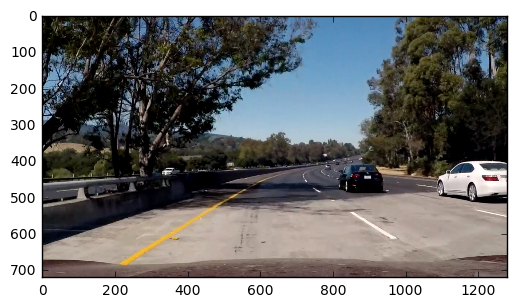

In [6]:
# Read in an image
imgIn = mpimg.imread(os.path.join(test_images, 'test5.jpg'))
plt.imshow(imgIn)

In [10]:
# Step 1: Compute Camera Calibration Matrix and Distortion Coefficients

def load_images(dir_path):
    """
    Load the camera images and return an array of images in the input dir.
    """
    return np.array([mpimg.imread(dir_path + image) for image in os.listdir(dir_path)])
    
    
def get_img_obj_points():
    """
    Use the camera_cal folder images to return the image points and object points
    @Returns: image_points array, object_points array, nx, ny
    """
    cal_img = load_images(camera_cal)
    nx = 9    # number of inner corners along x-axis
    ny = 6    # number of inner corners aling y-axis
    
    obj_points = []    # 3D points in real world space
    img_points = []    # 2D points in image space
    
    # Create a 6x9x3 points np array of object points like (0,0,0),(1,0,0),...,(2,3,0),...,(8,5,0)
    obj_pts = np.zeros([nx*ny, 3], np.float32)
    obj_pts[:,:,2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)    # Set the x and y coordinates
    
    for image in cal_images:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        
        # Find the chessboard corner
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        
        print(ret)
        if(ret):
            img_points.append(corners)
            obj_points.append(obj_points)
            
    return img_points, obj_points, nx, ny
    
def undistort_image(img, objPoints, imgPoints, nx, ny):
    """
    Performs camera calibration and image distortion correction
    @Returns: Undistorted image
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RBG2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objPoints, imgPoints, gray.shape[::-1], None, None)
    undist_img = cv2.undistort(img, mtx, dist, None, mtx)
        
    return undist_img
    

In [9]:
# np.mgrid[0:9, 0:6].T.reshape(-1, 2)

In [11]:
# Step 2: Thresholds to create a binary image

def abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(0, 255)):
    """
    Apply SobelX (by default), take the absolute value and apply a threshold to create a binary mask
    @Return: Image with SobelX or SobelY with the defined mask applied
    """
    img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    if(orient == 'x'):
        sobel = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    else:
        sobel = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return grad_binary

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    """
    Apply a threshold to the overall magnitude of the gradient, in x and y directions.
    """
    
    image = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Calculate derivative in the x and y direction
    sobelx = abs_sobel_thresh(image, 'x', sobel_kernel, mag_thresh)
    sobely = abs_sobel_thresh(image, 'y', sobel_kernel, mag_thresh)
    
    # Calculate the gradient magnitude
    abs_sobel = np.sqrt((sobelx**2) + (sobely**2))
    
    # Rescale to 8 bit
    gradmag = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Create a binary image of ones where threshold is met, zeros otherwise
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    
    return mag_binary

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    """
    Detect vertical lines. 
    Compute the direction of the gradient (arctan2(np.absolute(sobely), np.absolute(sobelx)))
    and apply it to each pixel of the image.
    Each pixel will contains a value for the angle of the gradient away from horizontal 
    in units of radians. 
    A value of (+/-) pi/2 indicate a vertical line.
    Apply this to the image as a mask, and return it.
    """
    
    image = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    dir_binary =  np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    
    return dir_binary

In [13]:
# HLS selection

def hls_select(image, channel=2, thresh=(0, 255)):
    """
    Select one of the H, L or S channels from the image.
    Takes the channel number to return as input
    0-H; 1-L; 2-S
    @Returns: the image with only one of the 3 channels
    """
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    req_channel = hls[:,:,channel]
    binary_output = np.zeros_like(req_channel)
    binary_output[(req_channel > thresh[0]) & (req_channel <= thresh[1])] = 1
    
    return binary_output

In [ ]:
# Step 3: Perspective Transform
# Pick 4 source points in a trapezoidal shape (similar to region masking), 
# that would represent a rectangle when looking down on the road from above.

def region_of_interest(image, vertices):
    """
    Applies an image mask.
    Only keeps the region of the image defined by the polygon formed from `vertices`.
    """
    
    # Defining a blank mask to start with
    mask = np.zeros_like(image)

    # Defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(image.shape) > 2:
        channel_count = image.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    # Filling pixels inside the polygon defined by "vertices" with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    # Feturning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(image, mask)
    
    return masked_image

def warp_image(image):
    """
    Transform the image's perspective within a certain region of interest.
    """
    
    img_size = (image.shape[1], image.shape[0])
    
    top_right_src = [735, 450]
    top_left_src = [560, 450]
    bottom_right_src = [1200, 705]
    bottom_left_src = [155, 705]

    vertices = np.array([[bottom_left_src, top_left_src, top_right_src, bottom_right_src]], dtype=np.int32)
    roi = region_of_interest(image, vertices)

    # src coordinates
    src = np.float32([top_right_src, bottom_right_src, bottom_left_src, top_left_src])  
    
    top_right_dest = [860, 100]
    top_left_dest = [155, 100]
    bottom_right_dest = [860, 705]
    bottom_left_dest = [155, 705]

    # dst coordinates
    dst = np.float32([top_right_dest, bottom_right_dest, bottom_left_dest, top_left_dest])

    # Compute the perspective transform
    M = cv2.getPerspectiveTransform(src, dst)

    # Compute the inverse matrix (will be used in the last steps)
    Minv = cv2.getPerspectiveTransform(dst, src)

    # Create waped image
    # keep same size as input image
    warped = cv2.warpPerspective(roi, M, image_size, flags=cv2.INTER_LINEAR)  
    
    return warped, Minv
    